## Import

In [39]:
from qibullet import SimulationManager
from qibullet import NaoVirtual , NaoFsr
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
import pickle
import random
import matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [41]:
if torch.cuda.is_available():
  device = "cuda" 
else:
  device = "cpu"
print(device, " in use")

cpu  in use


## Nao Bullet

In [42]:
# Launch Simulation Environment
vis = True
simulation_manager = SimulationManager()
nao_sim = simulation_manager.launchSimulation(gui=vis, auto_step=True)
#nao_sim_vis = simulation_manager.launchSimulation(gui=False, auto_step=True)
simulation_manager.setGravity(nao_sim, [0.0, 0.0, -9.81])
nao = None

# Utility Functions
# Joints to monitor
legJoints = [ "LHipRoll", "LHipPitch", "LKneePitch", "LAnklePitch", "LAnkleRoll",
              "RHipRoll", "RHipPitch", "RKneePitch", "RAnklePitch", "RAnkleRoll"]

min_values_tensor = torch.tensor([-0.37, -1.53, -0.09, -1.18, -0.39 , -0.79, -1.53, -0.10, -1.18, -0.76], dtype=torch.float32)
max_values_tensor = torch.tensor([ 0.79, 0.48, 2.11, 0.92, 0.76,  0.37, 0.48, 2.12, 0.93, 0.39], dtype=torch.float32)

min_values = [-0.38, -1.539, -0.099,	-1.19 , -0.399 ,	-0.792, -1.536, -0.105, -1.188, -0.769]
max_values = [ 0.795, 0.488, 2.118,0.923, 0.77,  0.38, 0.49, 2.13, 0.95,0.399]
bucket_width = 0.05

num_buckets = np.ceil((np.array(max_values) - np.array(min_values)) / bucket_width).astype(int)
bucket_edges_list = [np.linspace(start=min_value, stop=max_value, num=num_bucket+1) for min_value, max_value, num_bucket in zip(min_values, max_values, num_buckets)]

nao_prev_position_X = 0
nao_prev_position_Y = 0

prev_weight_cntr = 0
def env_Reward():
    global prev_weight_cntr
    x, y, z = nao.getPosition()
    terminated = False
    delX = 5*(x - nao_prev_position_X  )
    delY = 5*(y - nao_prev_position_Y  )
    weight = -(nao.getTotalFsrValues(NaoFsr.LFOOT) + nao.getTotalFsrValues(NaoFsr.RFOOT) )

    # if robot fallen down
    if weight == 0: 
        reward = 0
        prev_weight_cntr += 1
    else:
        reward = delX
        prev_weight_cntr = 0

    if prev_weight_cntr == 5:
        terminated = True
        reward = - 1
        prev_weight_cntr = 0
    return reward, terminated

def env_state():
    return nao.getAnglesPosition(legJoints)
    
def env_action(angles, speed):
    nao.setAngles(legJoints, angles ,speed)

def env_itrm_step(itr):
    for _ in range(itr):
        simulation_manager.stepSimulation(nao_sim)

def env_reset():
    global nao_prev_position_X , nao_prev_position_Y
    global nao
    simulation_manager.resetSimulation(nao_sim)
    simulation_manager.setGravity(nao_sim, [0.0, 0.0, -9.81])
    nao = simulation_manager.spawnNao( 
    nao_sim,
    translation=[0, 0, 0],quaternion=[0, 0, 0, 1],
    spawn_ground_plane=True)
    env_itrm_step(100)
    time.sleep(2)
    nao_prev_position_X, nao_prev_position_Y, _ = nao.getPosition()

def env_stop():
    simulation_manager.stopSimulation(nao_sim)
    # wait for limited iterations 

def env_step(angles):
    env_action(angles, 0.5)
    #env_itrm_step(50)
    time.sleep(0.5)
    reward, terminated = env_Reward()
    next_state = env_state()
    return next_state, reward, terminated

def env_Q_state():
    my_array = env_state()
    # Define a function to assign each element of the array to a bucket
    def assign_bucket(value):
        index = np.where(value == my_array)[0][0]  # Find the index of the value in the array
        bucket_edges = bucket_edges_list[index]   # Get the corresponding bucket edges
        bucket_index = np.searchsorted(bucket_edges, value, side='right') - 1  # Find the bucket index
        return bucket_index

    my_array = np.array(my_array)

    bucket_indices = [assign_bucket(value) for value in my_array]
    return bucket_indices
    
env_reset()


startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=VMware, Inc.
GL_RENDERER=llvmpipe (LLVM 10.0.0, 256 bits)
GL_VERSION=3.3 (Core Profile) Mesa 20.0.8
GL_SHADING_LANGUAGE_VERSION=3.30
pthread_getconcurrency()=0
Version = 3.3 (Core Profile) Mesa 20.0.8
Vendor = VMware, Inc.
Renderer = llvmpipe (LLVM 10.0.0, 256 bits)
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = VMware, Inc.
ven = VMware, Inc.


In [47]:
env_stop()

numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed


## Agent

In [43]:

## Agent 
class walk_Agent:
  def __init__(self, observation_space, action_space , epsilon, epsilon_decay):
    self.observation_space = observation_space
    self.action_space = action_space
    self.epsilon = epsilon
    self.epsilon_decay = epsilon_decay
    self.epsilon_array = list()
    self.epsilon_min = 0.35

  def step(self, obs, policy, Q):
    self.epsilon = max ( self.epsilon * self.epsilon_decay , self.epsilon_min)
    self.epsilon_array.append(self.epsilon)

    if policy == "e-greedy":

      if np.random.uniform() > self.epsilon:
    
        next_obs = []
        act = []
        for i in range(self.observation_space):
          idx = np.argmax( [ Q[3*i] , Q[3*i + 1], Q[3*i + 2] ])
          if idx == 0:
            next_obs.append( obs[i] + bucket_width)
            act.append(0)

          elif idx == 1:
            next_obs.append( obs[i] )
            act.append(1)

          elif idx == 2:
            next_obs.append( obs[i] - bucket_width)
            act.append(2)
          
      else:

        act = []
        next_obs = []
        for elem in obs:

          rnd_act = random.choice([ 0.1, 0, -0.1])
          
          if rnd_act == 0.1:
            next_obs.append(elem + bucket_width)
            act.append(0)
          
          elif rnd_act == 0:
            next_obs.append(elem)
            act.append(1)
          
          else:
            next_obs.append(elem - bucket_width)
            act.append(2)
        
      return next_obs , act

    elif policy == "random":
      return np.random.choice(self.action_space.n)

    elif policy == "optimal":
      return np.argmax(Q)
  
  def give_epsilon_history(self):
    return self.epsilon_array

## DQN

In [44]:
### Paramters
epsilon = 1
gamma = 0.9
epsilon_decay = 0.999

observation_space = 10
action_space= 20

## Environment Initialisation
agent = walk_Agent(observation_space, action_space, epsilon, epsilon_decay)

env_reset()
terminated = False

# BEGIN_YOUR_CODE
observation = env_state()
observation = np.array([observation], dtype='float32')

# Define Action Value model
class DQN_AV(nn.Module):
    def __init__(self):
        super().__init__()
        self.network_arch = nn.Sequential(
            nn.Linear(10, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 30)
        )

    def forward(self, x):
        out = self.network_arch(x)
        return out

AV = DQN_AV().to(device)
#print(model)


# Define Target Action model
class DQN_TA(nn.Module):
    def __init__(self):
        super().__init__()
        self.network_arch = nn.Sequential(
            nn.Linear(10, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 30)
        )

    def forward(self, x):
        out = self.network_arch(x)
        return out

TA = DQN_TA().to(device)
#print(model)

TA.load_state_dict(AV.state_dict())

input = torch.from_numpy(observation)
print("Observation : " , observation)

out = AV(input)
print("Q Values from Action Value : ", out.detach().numpy())

out = TA(input)
print("Q Values from Target Action : ", out.detach().numpy())

Observation :  [[ 0.11933001  0.12696193 -0.09232651  0.08701695 -0.11081475 -0.11916356
   0.12730536 -0.0923344   0.0867851   0.11116954]]
Q Values from Action Value :  [[-0.11874117 -0.10125618 -0.01200833  0.02571335  0.10584147 -0.06745173
   0.06017124 -0.00129769 -0.06409799 -0.0805539  -0.0114157   0.02199012
  -0.07894025  0.00808182  0.03094829 -0.01753118  0.03220341  0.04193366
  -0.0711465   0.07060177 -0.02010316 -0.00327753  0.03432719  0.12484895
   0.13039258 -0.02490954 -0.07420933 -0.01702947 -0.04905571 -0.05769888]]
Q Values from Target Action :  [[-0.11874117 -0.10125618 -0.01200833  0.02571335  0.10584147 -0.06745173
   0.06017124 -0.00129769 -0.06409799 -0.0805539  -0.0114157   0.02199012
  -0.07894025  0.00808182  0.03094829 -0.01753118  0.03220341  0.04193366
  -0.0711465   0.07060177 -0.02010316 -0.00327753  0.03432719  0.12484895
   0.13039258 -0.02490954 -0.07420933 -0.01702947 -0.04905571 -0.05769888]]


## Train

error: Error in the setAngles parameters

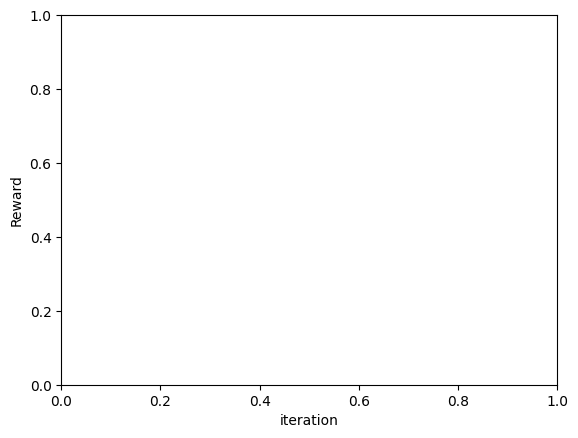

In [46]:
### Paramters
epsilon = 1
gamma = 0.9
epsilon_decay = 0.999

observation_space = 10
action_space= 10

policy = "e-greedy"

D = list()
avg_reward = 0
Cum_reward_arr = list()
no_of_timestep = list()

## Environment Initialisation
agent = walk_Agent(observation_space, action_space, epsilon, epsilon_decay)

## Reset
env_reset()
obs = env_state()
obs = np.array([obs], dtype='float32')
terminated = False


## Parameters
miniBatch = 4
C = 2
episodes = 10
M = 500
learning_rate = 0.01

optimizer = optim.AdamW(AV.parameters(), lr= learning_rate, amsgrad=True)

fig, ax = plt.subplots()
ax.set_xlabel("iteration")
ax.set_ylabel("Reward")

for m in range(M):
  
  D = list()
  for episode in range(episodes):

    itr = 0
    total_reward = 0

    with torch.no_grad():

      # Collect experiences
      while not terminated:

        itr = itr +1
        
        #obs = env_Q_state()
        #obs = np.array([obs], dtype='float32')
        #obs = torch.from_numpy(obs)
        
        obs = env_state() #np.array(obs)
        #obs = list( obs.flatten())
        obs = np.array([obs], dtype='float32')
        Q = AV(torch.tensor(obs, dtype=torch.float)) # 1d array of size 30
        
        ## Take Action
        new_state_req , action = agent.step(obs, policy, list( Q.numpy() )) # new_state_req are angles and action will 10*1 array of -1 , 1 , 0
        
        ## Observe reward and state
        new_obs, reward, terminated = env_step(list(new_state_req))

        ## Store in D 
        D.append([obs, action, reward, new_obs, terminated])

        ## Update State
        #obs = new_obs
        
        ## Cumulative reward
        total_reward += reward
        
        if(terminated):
            no_of_timestep.append(itr)
            break
      
      env_reset()
      obs = env_Q_state()
      obs = np.array([obs], dtype='float32')
      terminated = False
      Cum_reward_arr.append(total_reward)
      avg_reward =  0.05 * total_reward + (1-0.05) * avg_reward

  totol_loop = len(D)//miniBatch
  
# --------------------------------------------------
  for k in range(totol_loop):
    
    err = 0
    exp = list()
    pred = list()

    ## Sample random from miniBatch
    for i in range(miniBatch):
      idx = random.randint(1, len(D) -1)
      st, a,  r, st1, terminated = D[idx]

      if terminated:
        Q_exp = r * torch.ones(10)
      else:
        QT = TA(torch.tensor(st1, dtype=torch.float))
        QT = QT.view(-1, 3)
        max_values = QT.max(dim=1).values
        Q_exp = r + gamma*max_values

      Q = AV(torch.tensor(st, dtype=torch.float))
      Q = Q.view(-1, 3)
      idx = torch.tensor([ [a[0]], [a[1]], [a[2]], [a[3]], [a[4]], [a[5]], [a[6]], [a[7]], [a[8]], [a[9]]  ])
      Q_pred = torch.gather(Q, 1, idx).squeeze()

      exp.append(Q_exp)
      pred.append(Q_pred)
    
    #print(exp)
    #print(pred)

    expected = exp 
    predicted = pred 

    loss = torch.nn.functional.mse_loss(expected[0], predicted[0])
    
    optimizer.zero_grad()
    loss.backward()
    
    #torch.nn.utils.clip_grad_value_(AV.parameters(), 100)
    optimizer.step()

    ## Update after Every C step
    if k%C == 0:
      TA.load_state_dict(AV.state_dict())
  
  if (m)% 5 == 0:
    plt.plot(Cum_reward_arr)
    plt.plot(no_of_timestep)
    plt.pause(0.001)

    display.display(plt.gcf())
    display.clear_output(wait=True)

      

In [75]:
x = torch.tensor([1,2,3,4,5,6,7,8,9])
x = x.view(-1, 3)
torch.gather(x, 1, torch.tensor([0,1,0]))

RuntimeError: Index tensor must have the same number of dimensions as input tensor

RuntimeError: Index tensor must have the same number of dimensions as input tensor

In [77]:
x = torch.tensor([1,2,3,4,5,6,7,8,9])
x = x.view(-1, 3)
idx = torch.tensor([0,1,0])
idx = idx.repeat(x.size()[0], 1)  # repeat idx for each row of x
torch.gather(x, 1, idx)

tensor([[1, 2, 1],
        [4, 5, 4],
        [7, 8, 7]])

In [86]:
x = torch.tensor( [ [ 0.2308,  0.1351,  0.1310],
                    [ 0.3405, -0.1738,  0.0268],
                    [-0.3404, -0.1835, -0.0311],
                    [ 0.1829,  0.1309,  0.0402],
                    [ 0.0356, -0.1477,  0.0833],
                    [ 0.0149, -0.1418, -0.1558],
                    [ 0.1514, -0.0096, -0.0639],
                    [-0.0182,  0.2285, -0.2660],
                    [-0.0203, -0.1473,  0.1908],
                    [ 0.2329, -0.0408, -0.0517] ])

idx = torch.tensor([[0],[1],[0],[0],[1],[0],[0],[1],[0],[1] ])
torch.gather(x, 1, idx).squeeze()

tensor([ 0.2308, -0.1738, -0.3404,  0.1829, -0.1477,  0.0149,  0.1514,  0.2285,
        -0.0203, -0.0408])

In [36]:
nao.getAnglesPosition(legJoints)

[0.11860806640630592,
 0.12884769051249473,
 -0.09229718608198108,
 0.08667567864562271,
 -0.11086502016204691,
 -0.11894127989195233,
 0.12729024957515186,
 -0.09222518471334772,
 0.08818516055705587,
 0.11231001838456815]

In [37]:
env_Q_state()

[10, 33, 0, 25, 5, 13, 33, 0, 25, 18]

In [50]:
import torch
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc = nn.Linear(10, 10)

    def forward(self, x):
        x = self.fc(x)
        x = torch.sign(x)
        return x

model = MyModel()

In [53]:
model(torch.randn(1, 10))

tensor([[ 1., -1., -1., -1., -1.,  1., -1.,  1., -1.,  1.]],
       grad_fn=<SignBackward0>)

## THis is directly learning policy not value

In [54]:
import torch
import torch.nn as nn

class AV(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(10, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x)) 
        x = self.custom_activation(x)
        return x

    def custom_activation(self, x):
        x = torch.where(x < -0.33, torch.tensor(-1.0), x)
        x = torch.where((x >= -0.33) & (x <= 0.33), torch.tensor(0.0), x)
        x = torch.where(x > 0.33, torch.tensor(1.0), x)
        return x

model = MyModel()

In [58]:
model(torch.randn(1, 10))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<WhereBackward0>)